In [1]:
# TODO if have time:
# decrease training classes to only classes in testing data so it's comparable
# or better yet, if the class has more than 1 training, move some to testing to generate more classes for testing

In [2]:
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [421]:
import pandas as pd 
import cv2, numpy as np
from scipy.stats import norm
from scipy.misc import imread
import re
import time
import random
import pickle
import sys
import idx2numpy as idx
from copy import copy
import os
from datetime import datetime 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# keras
np.random.seed(666)
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics

# logging
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
rootpath = "../EgyptianHieroglyphDataset/MyTrainTest"

In [5]:
with open(os.path.join(rootpath, "dict.pkl"), "rb") as picklefile:
    symbol_df = pickle.load(picklefile)
with open(os.path.join(rootpath, "tr_filelist.pkl"), "rb") as picklefile:
    tr_filelist = pickle.load(picklefile)
with open(os.path.join(rootpath, "ts_filelist.pkl"), "rb") as picklefile:
    ts_filelist = pickle.load(picklefile)   

In [422]:
n_classes = symbol_df.shape[0]
n_train = tr_filelist.shape[0]
n_test = ts_filelist.shape[0]
batch_size = 32
        # TODO 32 is standard
        # decrease futher for small datasets, e.g. 32 // 2
        # increase if want estimates more stable
        # must be divisible by num training rows, must be int and not float
original_dim = (75, 50) # without convolutional layers, use 75 * 50
myinitializer = "glorot_uniform" 
        # default is "glorot_uniform" aka Xavier's initializer
        # TODO tried he_normal but not sure if this is helpful; change it back to default?
clf_myinitializer = "he_normal" 
conv1_filter = 8 
conv2_filter = 16 
conv3_filter = 64 
conv4_filter = 128 
# conv5_filter = 128 
window_size = 3
intermediate_dim = 32 
latent_dim = 10 # had it at 170 but Andrew didn't recommend it
epochs = 8 # 50
clf_epochs = 20 # 100
lr = 1 * 1e-3 # 0.001
clf_lr = 5 * 1e-5 # 0.001
epsilon_std = 1.0

In [7]:
symbol_dict = {}
for i in range(n_classes):
    symbol_dict[i] = symbol_df.loc[i, "symbol"]
symbol_one_hot = {}
for i in range(n_classes):
    symbol_one_hot[i] = np_utils.to_categorical(i, n_classes)

In [8]:
def get_img_array(filepath):
    img_array = imread(filepath, flatten = True, mode = "RGB").astype('float32') # flatten means grey scale
    img_array = np.reshape(img_array, (1,) + (original_dim)) / 255.
            # Andrew said not necessary to / 255. unless working with pre-trained data
            # but my example has / 255. and without it, I get very weird loss error
            # without convolutional layers, use np.reshape(arrayfile, original_dim) / 255.
            # with all 3 layers of rgb, use (3,) + (original_dim)
    return img_array

In [9]:
def mygenerator(train_test_filelist, n, encoder_clf):
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, 1) + original_dim)
    # print("empty batch_features")
    if encoder_clf == "clf":
        batch_labels = np.zeros((batch_size, n_classes))
        # print("empty batch_labels")
    # populate data
    while True:
        for i in range(batch_size):
            # print("row", i)
            index= random.choice(range(n)) # shuffle
            # print("index", index)
            batch_features[i] = get_img_array(train_test_filelist.loc[index, "fname"])
            # print("batch_feature", i, "populated")
            if encoder_clf == "clf":
                batch_labels[i] = symbol_one_hot[train_test_filelist.loc[index, "symbol_num"]]
                # print("batch_label", i, "populated") 
        # yield one batch worth of features and labels
        if encoder_clf == "clf":
            yield batch_features, batch_labels
        else:
            yield batch_features, batch_features

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [11]:
# Custom loss layerc
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, deconv1):
        flat_dim = np.prod(original_dim)
        x_reshaped = tf.reshape(x, (batch_size, flat_dim))
        deconv1_reshaped = tf.reshape(deconv1, (batch_size, flat_dim))
        xent_loss = flat_dim * metrics.binary_crossentropy(x_reshaped, deconv1_reshaped)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
                # Kullback-Leibler divergence
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        deconv1 = inputs[1]
        loss = self.vae_loss(x, deconv1)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
# class CustomVariationalLayer(Layer):
#     def __init__(self, **kwargs):
#         self.is_placeholder = True
#         super(CustomVariationalLayer, self).__init__(**kwargs)

#     def vae_loss(self, x, x_decoded_mean):
#         xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
#         kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         return K.mean(xent_loss + kl_loss)

#     def call(self, inputs):
#         x = inputs[0]
#         x_decoded_mean = inputs[1]
#         loss = self.vae_loss(x, x_decoded_mean)
#         self.add_loss(loss, inputs=inputs)
#         # We won't actually use the output.
#         return x

### build cvae

In [12]:
x = Input(batch_shape=(batch_size, 1) + (original_dim), name = "input")

In [13]:
# drop = Dropout(0.1)(x)

In [14]:
conv1 = Convolution2D(conv1_filter, (window_size, window_size), activation='relu', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv1")(x) # drop
conv2 = Convolution2D(conv2_filter, (window_size, window_size), activation='relu', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv2")(conv1)
conv3 = Convolution2D(conv3_filter, (window_size, window_size), activation='relu', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv3")(conv2)
conv4 = Convolution2D(conv4_filter, (window_size, window_size), activation='relu', padding='same', \
                      data_format="channels_first", kernel_initializer = myinitializer, name = "conv4")(conv3)
# conv5 = Convolution2D(conv5_filter, (window_size, window_size), activation='relu', padding='same', \
#                       data_format="channels_first", kernel_initializer = myinitializer, name = "conv5")(conv4)
flat = Flatten()(conv4) # conv5

In [15]:
h = Dense(intermediate_dim, activation='relu', kernel_initializer = myinitializer, name = "encoder1")(flat)
z_mean = Dense(latent_dim, name = "latent")(h)
z_log_var = Dense(latent_dim, name = "latent_var")(h)

In [16]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name = "lambda")([z_mean, z_log_var])

In [17]:
h_decoded = Dense(intermediate_dim, activation='relu', kernel_initializer = myinitializer, name = "decoder1")(z)
x_decoded_mean = Dense(flat._keras_shape[1], activation='relu', name = "deconv5")(h_decoded)
reshape = Reshape(target_shape = (conv4_filter, original_dim[0], original_dim[1]))(x_decoded_mean) # conv5_filter

In [18]:
# deconv5 = Convolution2D(conv4_filter, (window_size, window_size), activation='relu', padding='same', \
#                         data_format="channels_first", kernel_initializer = myinitializer, name = "deconv4")(reshape)
deconv4 = Convolution2D(conv3_filter, (window_size, window_size), activation='relu', padding='same', \
                        data_format="channels_first", kernel_initializer = myinitializer, \
                        name = "deconv3")(reshape) # deconv5
deconv3 = Convolution2D(conv2_filter, (window_size, window_size), activation='relu', padding='same', \
                        data_format="channels_first", kernel_initializer = myinitializer, \
                        name = "deconv2")(deconv4)
deconv2 = Convolution2D(conv1_filter, (window_size, window_size), activation='relu', padding='same', \
                        data_format="channels_first", \
                        kernel_initializer = myinitializer, name = "deconv1")(deconv3) 
deconv1 = Convolution2D(1, (window_size, window_size), activation='sigmoid', padding='same', \
                        data_format="channels_first", \
                        kernel_initializer = myinitializer, name = "reconstructed_x")(deconv2)

In [19]:
# print(x._keras_shape, "dropping", drop._keras_shape)
# print(conv1._keras_shape, "flatten", flat._keras_shape)
# print(h._keras_shape)
# print("latent", z_mean._keras_shape, z_log_var._keras_shape, "combined latent", z._keras_shape)
# print(h_decoded._keras_shape)
# print(x_decoded_mean._keras_shape, "reshape", reshape._keras_shape)
# print(deconv1._keras_shape)

In [20]:
y = CustomVariationalLayer()([x, deconv1])

In [21]:
vae = Model(inputs=x, outputs=y)

In [22]:
# rmsprop = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
adm = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        # Adam is a recently proposed update that looks a bit like RMSProp with momentum
# sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
vae.compile(optimizer=adm, loss=None)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  """


In [23]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (32, 1, 75, 50)       0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (32, 8, 75, 50)       80          input[0][0]                      
____________________________________________________________________________________________________
conv2 (Conv2D)                   (32, 16, 75, 50)      1168        conv1[0][0]                      
____________________________________________________________________________________________________
conv3 (Conv2D)                   (32, 64, 75, 50)      9280        conv2[0][0]                      
___________________________________________________________________________________________

### train cvae

In [ ]:
start = datetime.now()
history_callback = vae.fit_generator(mygenerator(tr_filelist, n_train, "encoder"),
        steps_per_epoch = n_train // batch_size, 
        epochs=epochs,
        verbose=1, # 2
        validation_data=mygenerator(ts_filelist, n_test, "encoder"), 
        validation_steps = n_test // batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

Epoch 1/8
1374/1374 [==============================] - 1411s - loss: 1894.5781 - val_loss: 2065.6680
Epoch 4/8
1374/1374 [==============================] - 1412s - loss: 1888.6973 - val_loss: 2072.7777
Epoch 5/8
1374/1374 [==============================] - 1412s - loss: 1883.8304 - val_loss: 2084.5953
Epoch 6/8
1374/1374 [==============================] - 1412s - loss: 1880.0096 - val_loss: 2070.7545
Epoch 7/8
1374/1374 [==============================] - 1412s - loss: 1875.5879 - val_loss: 2040.3406
runtime 188.38333333333333 minutes


In [ ]:
# history_callback.history['val_loss']

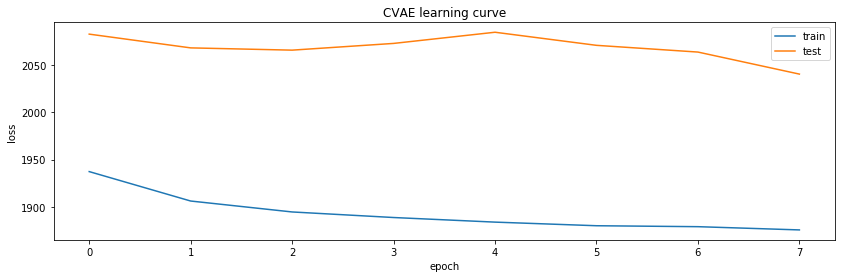

In [26]:
plt.figure(figsize = (14, 4))
xaxis = range(epochs)
plt.plot(xaxis, history_callback.history['loss'], label = "train")
plt.plot(xaxis, history_callback.history['val_loss'], label = "test")
plt.xlabel("epoch")
plt.ylabel("loss")
# plt.ylim([2060, 2065])
plt.title("CVAE learning curve")
plt.legend()
plt.show()

In [37]:
vae.save("../data/vae_2nd_try.h5")

In [38]:
with open("../data/vae_2nd_try_hist.pkl", "wb") as picklefile:
    pickle.dump(history_callback.history, picklefile)

### take a look at decoder results

- train

In [27]:
decoder = Model(inputs=x, outputs=deconv1)

In [64]:
one_tr_batch = next(mygenerator(tr_filelist, n_train, "encoder"))[0]
print(one_tr_batch.shape)
x_train_decoded = decoder.predict(one_tr_batch, batch_size=batch_size)

(32, 1, 75, 50)


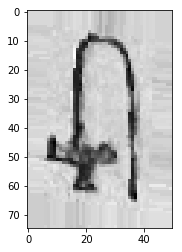

In [93]:
i = 8
one_tr_example = one_tr_batch[i][0]
# print(one_tr_example.shape)
plt.imshow(one_tr_example, cmap='gray')

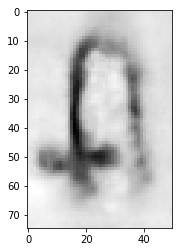

In [94]:
plt.imshow(x_train_decoded[i][0], cmap='gray')

- test

In [45]:
one_ts_batch = next(mygenerator(ts_filelist, n_test, "encoder"))[0]
print(one_ts_batch.shape)
x_test_decoded = decoder.predict(one_ts_batch, batch_size=batch_size)

(32, 1, 75, 50)


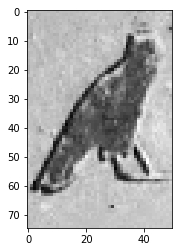

In [101]:
i = 4
one_ts_example = one_ts_batch[i][0]
# print(one_ts_example.shape)
plt.imshow(one_ts_example, cmap='gray')

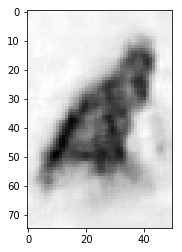

In [102]:
plt.imshow(x_test_decoded[i][0], cmap='gray')

### get a separate model (the encoder) that outputs latent features

In [51]:
# build a model to project inputs on the latent space
encoder = Model(inputs=x, outputs=z_mean)

In [425]:
encoder_wt = encoder.get_weights()

In [53]:
encoder.save("../data/encoder_2nd_try.h5")

### explore encoder result

- train

In [424]:
try:
    encoder
    print("encoder already exist. all is well")
except:
    print("loading encoder from file")
    encoder = load_model("../data/encoder_2nd_try.h5")

encoder already exist. all is well


In [55]:
# get some data
n_batches_to_display = int((n_train // batch_size) * 0.2) # display roughly 20% of cases based on sample w/ replacement
one_tr_batch_w_label = np.empty((0, 1) + (original_dim))
one_tr_batch_labels = np.empty((0, n_classes))
# print(one_tr_batch_w_label.shape, one_tr_batch_labels.shape)

for i in range(n_batches_to_display):
    temp_array, temp_label = next(mygenerator(tr_filelist, n_train, "clf"))
    # print(temp_array.shape, temp_label.shape)
    one_tr_batch_w_label = np.vstack([one_tr_batch_w_label, temp_array])
    one_tr_batch_labels = np.vstack([one_tr_batch_labels, temp_label])
    # print(one_tr_batch_w_label.shape, one_tr_batch_labels.shape)
print(batch_size * n_batches_to_display, one_tr_batch_w_label.shape, one_tr_batch_labels.shape)

8768 (8768, 1, 75, 50) (8768, 171)


In [56]:
start = datetime.now()
x_train_encoded = encoder.predict(one_tr_batch_w_label, batch_size=batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("encoding runtime", runtime, "minutes")

# x_train_tsne = np.log(x_train_encoded) # code for when I set exactly 2 latent features
tsne = TSNE(n_components = 2)
start = datetime.now()
x_train_tsne = tsne.fit_transform(x_train_encoded)
end = datetime.now()
runtime = (end - start).seconds / 60
print("tsne runtime", runtime, "minutes")

encoding runtime 0.36666666666666664 minutes
tsne runtime 3.25 minutes


In [57]:
# img=mpimg.imread(os.path.join(rootpath, "test", "070000_M17.png"))
# plt.imshow(img, cmap='gray')

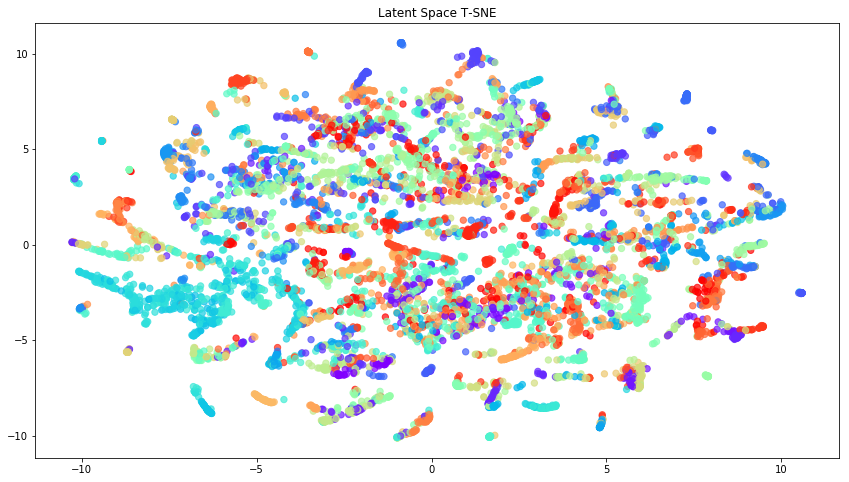

In [58]:
y_train_cat = pd.Series(np.argmax(one_tr_batch_labels, 1), name = "true")
plt.figure(figsize = (18, 8))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_train_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_train_tsne[:, 0],
            x_train_tsne[:, 1],
            **kwargs)
plt.show()

- just pick a few classes

In [103]:
y_train_cat = pd.Series(np.argmax(one_tr_batch_labels, 1), name = "true")
cond = y_train_cat.map(lambda x: x in (79, 155, 135, 59, 127, 153, 167, 44, 130, 158, 0))

In [ ]:
# manually figure out batch shape
# one_tr_batch_w_label[cond].shape
# 576 % batch_size

In [120]:
one_tr_batch_w_label = one_tr_batch_w_label[cond][:-1]
y_train_cat = y_train_cat[cond][:-1]

In [124]:
start = datetime.now()
x_train_encoded = encoder.predict(one_tr_batch_w_label, batch_size=batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("encoding runtime", runtime, "minutes")

# x_train_tsne = np.log(x_train_encoded) # code for when I set exactly 2 latent features
tsne = TSNE(n_components = 2)
start = datetime.now()
x_train_tsne = tsne.fit_transform(x_train_encoded)
end = datetime.now()
runtime = (end - start).seconds / 60
print("tsne runtime", runtime, "minutes")

encoding runtime 0.016666666666666666 minutes
tsne runtime 0.05 minutes


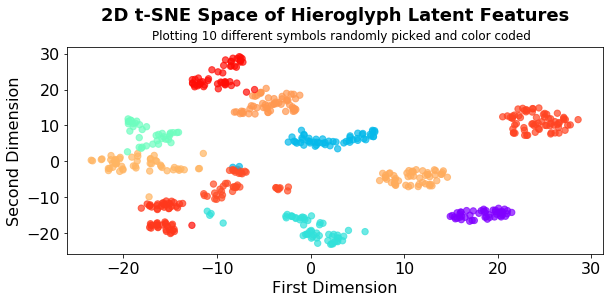

In [152]:
# y_train_cat = pd.Series(np.argmax(one_tr_batch_labels, 1), name = "true")
plt.figure(figsize = (12, 3.8))
plt.title("2D t-SNE Space of Hieroglyph Latent Features\n", fontsize = 18, fontweight = "bold")
plt.text(-17, 34, "Plotting 10 different symbols randomly picked and color coded", fontsize = 12)
plt.xlabel("First Dimension", fontsize = 16)
plt.ylabel("Second Dimension", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_train_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_train_tsne[:, 0],
            x_train_tsne[:, 1],
            **kwargs)
plt.show()

- test (more like a holdout since this is unsupervised learning)

In [153]:
# get some data
n_batches_to_display = int((n_test // batch_size) * 2) 
        # display roughly 400% of cases based on sample w/ replacement
        # good thing about this is I only have 67 classes in testing
one_ts_batch_w_label = np.empty((0, 1) + (original_dim))
one_ts_batch_labels = np.empty((0, n_classes))

for i in range(n_batches_to_display):
    temp_array, temp_label = next(mygenerator(ts_filelist, n_test, "clf"))
    one_ts_batch_w_label = np.vstack([one_ts_batch_w_label, temp_array])
    one_ts_batch_labels = np.vstack([one_ts_batch_labels, temp_label])
print(batch_size * n_batches_to_display, one_ts_batch_w_label.shape, one_ts_batch_labels.shape)

1024 (1024, 1, 75, 50) (1024, 171)


In [154]:
start = datetime.now()
x_test_encoded = encoder.predict(one_ts_batch_w_label, batch_size=batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("encode runtime", runtime, "minutes")

start = datetime.now()
x_test_tsne = tsne.fit_transform(x_test_encoded)
end = datetime.now()
runtime = (end - start).seconds / 60
print("tsne runtime", runtime, "minutes")

encode runtime 0.03333333333333333 minutes
tsne runtime 0.18333333333333332 minutes


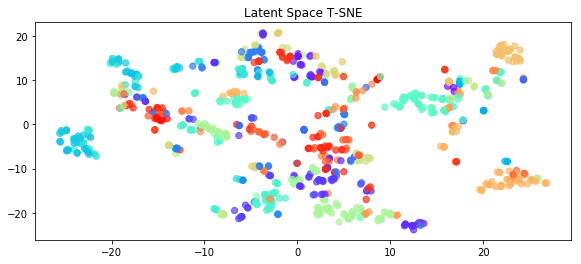

In [155]:
y_test_cat = pd.Series(np.argmax(one_ts_batch_labels, 1), name = "true")
plt.figure(figsize = (12, 4))
plt.title("Latent Space T-SNE")
kwargs = {'alpha': 0.7, 's': 40}

classes = set(symbol_df["symbol_num"])
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in y_test_cat]
    #kwargs['marker'] = r'$\diamondsuit$' # TODO customize marker shape. Do it in D3?
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
               for i, class_ in enumerate(classes)]
#     ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
#               fancybox=True, loc='center left')
    
plt.scatter(x_test_tsne[:, 0],
            x_test_tsne[:, 1],
            **kwargs)
plt.show()

### build classifier based on latent features

In [431]:
# encoder = load_model("../data/encoder_2nd_try.h5")
# encoder_wt = encoder.get_weights()

In [434]:
try:
    del clf
except:
    pass
finally:
    clf = Sequential()
    n_encoder_layers = len(encoder.layers)
    for i in range(n_encoder_layers):
        clf.add(encoder.layers[i])
    clf.set_weights(encoder_wt) # loading encoder results as an initial value helps tremendously
    
    for layer in clf.layers:
        layer.trainable = True # loss doesn't go down when I'm freezing encoder layers 
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm1'))
    # clf.add(Dropout(0.4, name="clf_drop1"))
    clf.add(Dense(1024, activation='tanh', kernel_initializer = clf_myinitializer, name='clf1'))
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm2'))
    clf.add(Dropout(0.4, name="clf_drop2"))
    clf.add(Dense(1024, activation='tanh', kernel_initializer = clf_myinitializer, name='clf2'))
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm3'))
    clf.add(Dropout(0.4, name="clf_drop3"))
    clf.add(Dense(1024, activation='tanh', kernel_initializer = clf_myinitializer, name='clf3'))
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm4'))
    clf.add(Dropout(0.5, name="clf_drop4"))
    clf.add(Dense(n_classes, activation='softmax', name='predictions'))

InternalError: Dst tensor is not initialized.
	 [[Node: _arg_Placeholder_8_0_10/_249 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_60__arg_Placeholder_8_0_10", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

In [428]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (32, 1, 75, 50)           0         
_________________________________________________________________
conv1 (Conv2D)               (32, 8, 75, 50)           80        
_________________________________________________________________
conv2 (Conv2D)               (32, 16, 75, 50)          1168      
_________________________________________________________________
conv3 (Conv2D)               (32, 64, 75, 50)          9280      
_________________________________________________________________
conv4 (Conv2D)               (32, 128, 75, 50)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (32, 480000)              0         
_________________________________________________________________
encoder1 (Dense)             (32, 32)                  15360032  
__________

In [ ]:
# compile model
# sgd = SGD(lr=clf_lr, decay=1e-6, momentum=0.9, nesterov=True) 
adm = Adam(lr=clf_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
clf.compile(optimizer=adm, loss='categorical_crossentropy')

### train classifier

In [ ]:
start = datetime.now()
clf_history_callback = clf.fit_generator(mygenerator(tr_filelist, n_train, "clf"),
        steps_per_epoch = n_train // batch_size, 
        epochs=clf_epochs,
        verbose=1, # 2
        validation_data=mygenerator(ts_filelist, n_test, "clf"), 
        validation_steps = n_test // batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")
# clf.save("../data/clf_2nd_try_interim.h5") # run this line if want to continue training

# clf_history_callback = clf.fit(x_train, y_train,
#         shuffle=True, # False
#         epochs=clf_epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, y_test))

Epoch 1/20
1374/1374 [==============================] - 751s - loss: 2.4242 - val_loss: 2.3705
Epoch 4/20
1374/1374 [==============================] - 752s - loss: 1.0664 - val_loss: 2.4165
Epoch 11/20
1374/1374 [==============================] - 752s - loss: 0.9750 - val_loss: 1.9939
Epoch 12/20
1374/1374 [==============================] - 751s - loss: 0.9048 - val_loss: 2.0406
Epoch 13/20
1374/1374 [==============================] - 751s - loss: 0.8473 - val_loss: 2.0574
Epoch 14/20
1374/1374 [==============================] - 751s - loss: 0.7782 - val_loss: 2.0214
Epoch 15/20
1374/1374 [==============================] - 751s - loss: 0.7217 - val_loss: 1.9157
Epoch 16/20
1374/1374 [==============================] - 751s - loss: 0.7018 - val_loss: 1.7237
Epoch 17/20
1374/1374 [==============================] - 751s - loss: 0.6475 - val_loss: 1.7705
Epoch 18/20
1374/1374 [==============================] - 751s - loss: 0.6032 - val_loss: 2.1281
Epoch 19/20
1374/1374 [===================

In [429]:
# continue training from the last epoch
temp = load_model("../data/clf_2nd_try_interim.h5")
pretrained_clf_wt = temp.get_weights()
# clf.set_weights(pretrained_clf_wt)

ResourceExhaustedError: OOM when allocating tensor with shape[480000,32]
	 [[Node: encoder1_29/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3148606, _device="/job:localhost/replica:0/task:0/gpu:0"](encoder1_29/random_uniform/shape)]]

Caused by op 'encoder1_29/random_uniform/RandomUniform', defined at:
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-429-678405fc089a>", line 2, in <module>
    temp = load_model("../data/clf_2nd_try_interim.h5")
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py", line 246, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py", line 1217, in from_config
    model.add(layer)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py", line 476, in add
    output_tensor = layer(self.outputs[0])
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 569, in __call__
    self.build(input_shapes[0])
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 830, in build
    constraint=self.kernel_constraint)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3446, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 236, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 249, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[480000,32]
	 [[Node: encoder1_29/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=3148606, _device="/job:localhost/replica:0/task:0/gpu:0"](encoder1_29/random_uniform/shape)]]


In [427]:
start = datetime.now()
clf_history_callback_new_and_better = clf.fit_generator(mygenerator(tr_filelist, n_train, "clf"),
        steps_per_epoch = n_train // batch_size, 
        epochs=10, # clf_epochs
        verbose=1, # 2
        validation_data=mygenerator(ts_filelist, n_test, "clf"), 
        validation_steps = n_test // batch_size)
end = datetime.now()
runtime = (end - start).seconds / 60
print("runtime", runtime, "minutes")

RuntimeError: You must compile your model before using it.

In [ ]:
# alternative code for continuous training
# with tf.Session() as sess:
#     ..something..
#     checkpoint_path = os.path.join(FLAGS.train_dir, "model.ckpt")
#     model.saver.save(sess, checkpoint_path, global_step=model.global_step)
    
# if ckpt and tf.train.checkpoint_exists(ckpt):
#     logging.info("Reading model parameters from %s" % ckpt)
#     model.saver.restore(session, ckpt)

# then, model.run(..something..)?

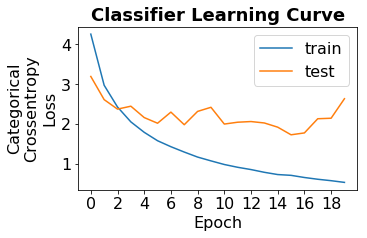

In [406]:
plt.figure(figsize = (5, 3))
xaxis = range(clf_epochs)
plt.plot(xaxis, clf_history_callback.history['loss'], label = "train")
plt.plot(xaxis, clf_history_callback.history['val_loss'], label = "test")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Categorical\nCrossentropy\nLoss", fontsize = 16)
plt.title("Classifier Learning Curve", fontsize = 18, fontweight = "bold")
plt.xticks(list(range(0, 20, 2)), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [ ]:
clf.save("../data/clf_2nd_try.h5")

In [ ]:
with open("../data/clf_2nd_try_hist.pkl", "wb") as picklefile:
    pickle.dump(clf_history_callback.history, picklefile)

### explore classifier performance

- get training data

In [ ]:
# TODO make this more rigorous and not based on generator
n_batches_to_display = int((n_train // batch_size) * 0.1) # display roughly 10% of cases based on sample w/ replacement
one_tr_batch_w_label = np.empty((0, 1) + (original_dim))
one_tr_batch_labels = np.empty((0, n_classes))

for i in range(n_batches_to_display):
    temp_array, temp_label = next(mygenerator(tr_filelist, n_train, "clf"))
    one_tr_batch_w_label = np.vstack([one_tr_batch_w_label, temp_array])
    one_tr_batch_labels = np.vstack([one_tr_batch_labels, temp_label])
print(batch_size * n_batches_to_display, one_tr_batch_w_label.shape, one_tr_batch_labels.shape)

4384 (4384, 1, 75, 50) (4384, 171)


In [ ]:
train_pred = clf.predict(one_tr_batch_w_label, batch_size=batch_size)

In [ ]:
train_pred_cat = pd.Series(np.argmax(train_pred, 1), name = "pred")
y_train_cat = pd.Series(np.argmax(one_tr_batch_labels, 1), name = "true")

In [ ]:
tr_accuracy = accuracy_score(y_train_cat, train_pred_cat)
tr_misclassified = y_train_cat != train_pred_cat
tr_n_misclassified = sum(tr_misclassified)
print("training accuracy", tr_accuracy, "misclassified =", tr_n_misclassified, "/", len(y_train_cat))

training accuracy 0.909671532847 misclassified = 396 / 4384


- get test data

In [ ]:
# TODO make this more rigorous and not based on generator
n_batches_to_display = int((n_test // batch_size) * 1) # display roughly 100% of cases based on sample w/ replacement
one_ts_batch_w_label = np.empty((0, 1) + (original_dim))
one_ts_batch_labels = np.empty((0, n_classes))

for i in range(n_batches_to_display):
    temp_array, temp_label = next(mygenerator(ts_filelist, n_test, "clf"))
    one_ts_batch_w_label = np.vstack([one_ts_batch_w_label, temp_array])
    one_ts_batch_labels = np.vstack([one_ts_batch_labels, temp_label])
print(batch_size * n_batches_to_display, one_ts_batch_w_label.shape, one_ts_batch_labels.shape)

512 (512, 1, 75, 50) (512, 171)


In [ ]:
test_pred = clf.predict(one_ts_batch_w_label, batch_size=batch_size)

In [ ]:
test_pred_cat = pd.Series(np.argmax(test_pred, 1), name = "pred")
y_test_cat = pd.Series(np.argmax(one_ts_batch_labels, 1), name = "true")

In [ ]:
accuracy = accuracy_score(y_test_cat, test_pred_cat)
misclassified = y_test_cat != test_pred_cat
n_misclassified = sum(misclassified)
print("validation accuracy", accuracy, "misclassified =", n_misclassified, "/", len(y_test_cat))
# for avg in ["micro", "macro"]:
#     accuracy = accuracy_score(y_test_cat, test_pred_cat)
#     precision = precision_score(y_test_cat, test_pred_cat, average = avg)
#     recall = recall_score(y_test_cat, test_pred_cat, average = avg)
#     f1 = f1_score(y_test_cat, test_pred_cat, average = avg)
#     print(avg, "average: accuracy", format(accuracy, "6.4f"), \
#           "precision", format(precision, "6.4f"), \
#           "recall", format(recall, "6.4f"), \
#           "f1", format(f1, "6.4f"))

validation accuracy 0.578125 misclassified = 216 / 512


- output

In [ ]:
print("training accuracy", tr_accuracy, "misclassified =", tr_n_misclassified, "/", len(y_train_cat))
print("validation accuracy", accuracy, "misclassified =", n_misclassified, "/", len(y_test_cat))

training accuracy 0.909671532847 misclassified = 396 / 4384
validation accuracy 0.578125 misclassified = 216 / 512


In [ ]:
# TODO append all of the callbacks together


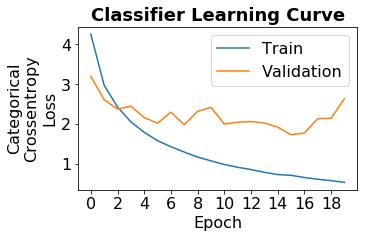

In [461]:
plt.figure(figsize = (5, 3))
xaxis = range(clf_epochs)
plt.plot(xaxis, clf_history_callback.history['loss'], label = "Train")
plt.plot(xaxis, clf_history_callback.history['val_loss'], label = "Validation")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Categorical\nCrossentropy\nLoss", fontsize = 16)
plt.title("Classifier Learning Curve", fontsize = 18, fontweight = "bold")
plt.xticks(list(range(0, clf_epochs, 2)), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [460]:
print("Validation Accuracy " + str(format(accuracy * 100, "6.2f")) + "%")
print("Random Chance Accuracy 1/171 = 0.58%")

Validation Accuracy  57.81%
Random Chance Accuracy 1/171 = 0.58%


In [ ]:
# pd.crosstab(test_pred_cat, y_test_cat)

- check misclassified cases

In [248]:
i = 0
raw_index = list(train_pred_cat[tr_misclassified].index)
print("true", symbol_dict[list(y_train_cat[tr_misclassified])[i]], \
      "predicted to be", symbol_dict[list(train_pred_cat[tr_misclassified])[i]])

true V31 predicted to be V30


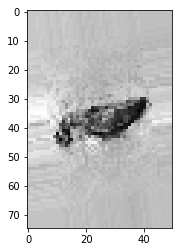

In [249]:
plt.figure()
plt.imshow(one_tr_batch_w_label[raw_index][i][0], cmap='gray')
plt.show()

- check correctly classified cases

In [246]:
i = 19
raw_index = list(train_pred_cat[tr_misclassified == False].index)
print("true", symbol_dict[list(y_train_cat[tr_misclassified == False])[i]], \
      "predicted to be", symbol_dict[list(train_pred_cat[tr_misclassified == False])[i]])

true G37 predicted to be G37


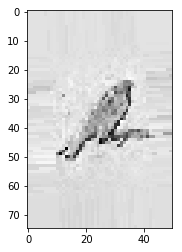

In [247]:
plt.figure()
plt.imshow(one_tr_batch_w_label[raw_index][i][0], cmap='gray')
plt.show()